In [3]:
!pip install sacrebleu

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
from tensorflow.keras.preprocessing.text import Tokenizer
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.layers import Input, LSTM, Dense, Embedding
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt

In [6]:
path_to_train = '/content/drive/MyDrive/Seq2Seq/balanced_train.csv'
path_to_val = '/content/drive/MyDrive/Seq2Seq/val.csv'
train_df = pd.read_csv(path_to_train)
val_df = pd.read_csv(path_to_val)
# print(df.shape)

In [7]:
def preprocess_sentence(sentence):
    sentence = sentence.lower().strip()
    sentence = sentence.replace("¿", "").replace("?", "").replace("©", "")
    sentence = sentence.replace(".", "").replace(",", "").replace("!", "").replace("¡", "")
    return sentence

In [8]:
for df in [train_df, val_df]:
    df['english'] = df['english'].apply(preprocess_sentence)
    df['spanish'] = df['spanish'].apply(preprocess_sentence)
    df['spanish'] = df['spanish'].apply(lambda x: '<sos> ' + x + ' <eos>')

In [9]:
# # Compute sentence lengths
# df['english_len'] = df['english'].apply(lambda x: len(x.split()))
# df['spanish_len'] = df['spanish'].apply(lambda x: len(x.split()))

# # Plot histogram
# plt.figure(figsize=(12, 6))
# plt.hist(df['english_len'], bins=50, alpha=0.6, label='English Sentence Length')
# plt.hist(df['spanish_len'], bins=50, alpha=0.6, label='spanish Sentence Length')
# plt.title("Sentence Length Distribution")
# plt.xlabel("Sentence Length (words)")
# plt.ylabel("Frequency")
# plt.legend()
# plt.grid(True)
# plt.tight_layout()
# plt.show()

In [ ]:

# Tokenization 
def data_preprocessor(sentences):
    tokenizer = Tokenizer(filters='')
    tokenizer.fit_on_texts(sentences)
    sequences = tokenizer.texts_to_sequences(sentences)
    return sequences, tokenizer

train_inputs, source_tokenizer = data_preprocessor(train_df['english'])
train_target_sequences, target_tokenizer = data_preprocessor(train_df['spanish'])

val_inputs = source_tokenizer.texts_to_sequences(val_df['english'])
val_target_sequences = target_tokenizer.texts_to_sequences(val_df['spanish'])

In [ ]:
#  decoder inputs and targets
train_dec_in = [seq[:-1] for seq in train_target_sequences]
train_targets = [seq[1:] for seq in train_target_sequences]

val_dec_in = [seq[:-1] for seq in val_target_sequences]
val_targets = [seq[1:] for seq in val_target_sequences]

In [12]:
# Vocabulary sizes
num_encoder_tokens = len(source_tokenizer.word_index) + 1
num_decoder_tokens = len(target_tokenizer.word_index) + 1

In [13]:
def is_not_empty(seq):
    return len(seq) > 0 and any(token != 0 for token in seq)

# Filter empty sequences and ensure equal lengths
def filter_sequences(enc_seqs, dec_in_seqs, dec_tar_seqs):
    filtered_enc, filtered_dec_in, filtered_dec_tar = [], [], []

    for enc, dec_in, dec_tar in zip(enc_seqs, dec_in_seqs, dec_tar_seqs):
        if is_not_empty(enc) and is_not_empty(dec_in) and is_not_empty(dec_tar):
            filtered_enc.append(enc)
            filtered_dec_in.append(dec_in)
            filtered_dec_tar.append(dec_tar)

    return filtered_enc, filtered_dec_in, filtered_dec_tar

In [14]:
train_inputs, train_dec_in, train_targets = filter_sequences(train_inputs, train_dec_in, train_targets)
val_inputs, val_dec_in, val_targets = filter_sequences(val_inputs, val_dec_in, val_targets)

print(f"Training samples: {len(train_inputs)}")
print(f"Validation samples: {len(val_inputs)}")

Training samples: 113148
Validation samples: 8105


In [15]:
# Convert sequences to tf.data.Dataset
def map_func(enc_inp, dec_inp, dec_tar):
    return ({
        'encoder_inputs': enc_inp,
        'decoder_inputs': dec_inp
    }, dec_tar)

train_dataset = tf.data.Dataset.from_tensor_slices((
    tf.ragged.constant(train_inputs),
    tf.ragged.constant(train_dec_in),
    tf.ragged.constant(train_targets)
)).map(map_func)

val_dataset = tf.data.Dataset.from_tensor_slices((
    tf.ragged.constant(val_inputs),
    tf.ragged.constant(val_dec_in),
    tf.ragged.constant(val_targets)
)).map(map_func)


In [16]:
# Applying DYNAMIC padding
BATCH_SIZE = 32
BUFFER_SIZE = 10000

train_dataset = train_dataset.shuffle(BUFFER_SIZE).padded_batch(
    BATCH_SIZE,
    padded_shapes=({
        'encoder_inputs': [None],
        'decoder_inputs': [None]
    }, [None]),
    padding_values=({
        'encoder_inputs': 0,
        'decoder_inputs': 0
    }, 0)
)

val_dataset = val_dataset.padded_batch(
    BATCH_SIZE,
    padded_shapes=({
        'encoder_inputs': [None],
        'decoder_inputs': [None]
    }, [None]),
    padding_values=({
        'encoder_inputs': 0,
        'decoder_inputs': 0
    }, 0)
)

In [17]:
embedding_dim = 128
latent_dim = 256

from tensorflow.keras.layers import Dot, Activation, Concatenate

# Inputs
encoder_inputs = Input(shape=(None,), name='encoder_inputs')
decoder_inputs = Input(shape=(None,), name='decoder_inputs')

# Embeddings
encoder_embedding = Embedding(num_encoder_tokens, embedding_dim, mask_zero=True)(encoder_inputs)
decoder_embedding = Embedding(num_decoder_tokens, embedding_dim, mask_zero=True)(decoder_inputs)

# Encoder
encoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True)
encoder_outputs, state_h, state_c = encoder_lstm(encoder_embedding)

# Decoder
decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(decoder_embedding, initial_state=[state_h, state_c])

In [18]:
# Custom Attention Layer
class BahdanauAttention(tf.keras.layers.Layer):
    def __init__(self, units):
        super(BahdanauAttention, self).__init__()
        self.W1 = tf.keras.layers.Dense(units)
        self.W2 = tf.keras.layers.Dense(units)
        self.V = tf.keras.layers.Dense(1)

    def call(self, query, values, mask=None):

        # Expand query to match values time steps
        query_with_time_axis = tf.expand_dims(query, 2)  # (batch_size, max_length, 1, hidden_size)
        values_with_time_axis = tf.expand_dims(values, 1)  # (batch_size, 1, max_length, hidden_size)

        # Calculate attention scores
        score = self.V(tf.nn.tanh(
            self.W1(query_with_time_axis) + self.W2(values_with_time_axis)))

        # Removes last dimension: (batch_size, max_length, max_length)
        score = tf.squeeze(score, axis=-1)

        if mask is not None:
          # Applying large negative value to padding positions
          score += (mask * -1e9)

        # Applying softmax
        attention_weights = tf.nn.softmax(score, axis=-1)

        # Applying attention weights to values
        context_vector = tf.matmul(attention_weights, values)

        return context_vector, attention_weights


In [19]:
# Apply custom attention
attention_layer = BahdanauAttention(latent_dim)
attention_output, attention_weights = attention_layer(decoder_outputs, encoder_outputs)

# Combine and output
decoder_concat = Concatenate(axis=-1)([decoder_outputs, attention_output])
decoder_dense = Dense(num_decoder_tokens, activation='softmax')
decoder_outputs_final = decoder_dense(decoder_concat)

# Build and compile
model = Model([encoder_inputs, decoder_inputs], decoder_outputs_final)
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

print("Model summary:")
model.summary()

Model summary:


/usr/local/lib/python3.11/dist-packages/keras/src/layers/layer.py:938: UserWarning: Layer 'bahdanau_attention' (of type BahdanauAttention) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ encoder_inputs      │ (None, None)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_inputs      │ (None, None)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, None, 128) │  1,339,392 │ encoder_inputs[0… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal           │ (None, None)      │          0 │ encoder_inputs[0… │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_1         │ (None, None, 128) │  2,340,352 │ decoder_inputs[0… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm (LSTM)         │ [(None, None,     │    394,240 │ embedding[0][0],  │
│                     │ 256), (None,      │            │ not_equal[0][0]   │
│                     │ 256), (None,      │            │                   │
│                     │ 256)]             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_1 (LSTM)       │ [(None, None,     │    394,240 │ embedding_1[0][0… │
│                     │ 256), (None,      │            │ lstm[0][1],       │
│                     │ 256), (None,      │            │ lstm[0][2]        │
│                     │ 256)]             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bahdanau_attention  │ [(None, None,     │    131,841 │ lstm_1[0][0],     │
│ (BahdanauAttention) │ 256), (None,      │            │ lstm[0][0]        │
│                     │ None, None)]      │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, None, 512) │          0 │ lstm_1[0][0],     │
│ (Concatenate)       │                   │            │ bahdanau_attenti… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, None,      │  9,379,692 │ concatenate[0][0] │
│                     │ 18284)            │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 13,979,757 (53.33 MB)

 Trainable params: 13,979,757 (53.33 MB)

 Non-trainable params: 0 (0.00 B)

In [20]:
#  sample batch
for batch in train_dataset.take(1):
    print("Sample batch shapes:")
    print("Encoder input shape:", batch[0]['encoder_inputs'].shape)
    print("Decoder input shape:", batch[0]['decoder_inputs'].shape)
    print("Target shape:", batch[1].shape)
    print("Sample encoder input:", batch[0]['encoder_inputs'].numpy()[0])
    print("Sample decoder input:", batch[0]['decoder_inputs'].numpy()[0])
    print("Sample target:", batch[1].numpy()[0])

Sample batch shapes:
Encoder input shape: (32, 10)
Decoder input shape: (32, 11)
Target shape: (32, 11)
Sample encoder input: [  20  674 1156    1  502    0    0    0    0    0]
Sample decoder input: [   1   25 1083    4  830    7  464    0    0    0    0]
Sample target: [  25 1083    4  830    7  464    2    0    0    0    0]


In [21]:
from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)
# Train the model
history = model.fit(train_dataset, validation_data=val_dataset, epochs=10, callbacks=[early_stop])

Epoch 1/10
3536/3536 ━━━━━━━━━━━━━━━━━━━━ 241s 66ms/step - accuracy: 0.5096 - loss: 3.4291 - val_accuracy: 0.6786 - val_loss: 1.8857
Epoch 2/10
3536/3536 ━━━━━━━━━━━━━━━━━━━━ 234s 66ms/step - accuracy: 0.7276 - loss: 1.4223 - val_accuracy: 0.7359 - val_loss: 1.5067
Epoch 3/10
3536/3536 ━━━━━━━━━━━━━━━━━━━━ 234s 66ms/step - accuracy: 0.8435 - loss: 0.7232 - val_accuracy: 0.7540 - val_loss: 1.4393
Epoch 4/10
3536/3536 ━━━━━━━━━━━━━━━━━━━━ 260s 66ms/step - accuracy: 0.9001 - loss: 0.4365 - val_accuracy: 0.7606 - val_loss: 1.4490
Epoch 5/10
3536/3536 ━━━━━━━━━━━━━━━━━━━━ 232s 66ms/step - accuracy: 0.9313 - loss: 0.2908 - val_accuracy: 0.7641 - val_loss: 1.4924


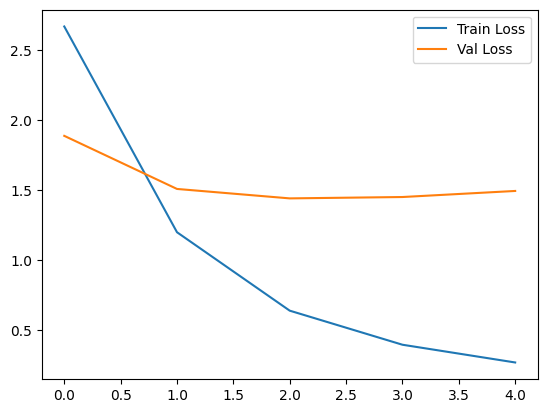

In [22]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend()
plt.show()

In [23]:
# model.summary()

In [24]:
for i, layer in enumerate(model.layers):
    print(f"{i}: {layer.name} ({layer.__class__.__name__})")


0: encoder_inputs (InputLayer)
1: decoder_inputs (InputLayer)
2: embedding (Embedding)
3: embedding_1 (Embedding)
4: lstm (LSTM)
5: lstm_1 (LSTM)
6: bahdanau_attention (BahdanauAttention)
7: concatenate (Concatenate)
8: dense_3 (Dense)


In [25]:
# Inference models
encoder_model = Model(encoder_inputs, [encoder_outputs, state_h, state_c])

# Decoder inference model inputs
decoder_inputs_single = Input(shape=(1,), name='decoder_input_token')
decoder_state_input_h = Input(shape=(latent_dim,), name='decoder_h')
decoder_state_input_c = Input(shape=(latent_dim,), name='decoder_c')
encoder_outputs_input = Input(shape=(None, latent_dim), name='encoder_outputs_input')



# reuse trained embedding weights
decoder_embedding_inf = model.get_layer(index=3)
decoder_embedding_single = decoder_embedding_inf(decoder_inputs_single)

# LSTM step for inference
decoder_lstm_inf = model.get_layer(index=5)
decoder_outputs_inf, state_h_inf, state_c_inf = decoder_lstm_inf(
    decoder_embedding_single, initial_state=[decoder_state_input_h, decoder_state_input_c]
)

# Attention for inference
attention_layer_inf = attention_layer  # reuse the trained one
attention_output_inf, _ = attention_layer_inf(decoder_outputs_inf, encoder_outputs_input)

# Combine and predict
decoder_concat_inf = Concatenate(axis=-1)([decoder_outputs_inf, attention_output_inf])
# decoder_dense_inf = Dense(num_decoder_tokens, activation='softmax')
decoder_dense_inf = model.get_layer(index=8)
decoder_outputs_final_inf = decoder_dense_inf(decoder_concat_inf)

# Define inference decoder model
decoder_model = Model(
    inputs=[decoder_inputs_single, encoder_outputs_input, decoder_state_input_h, decoder_state_input_c],
    outputs=[decoder_outputs_final_inf, state_h_inf, state_c_inf]
)


In [ ]:
def translate(input_text):
    # Preprocess input
    input_seq = source_tokenizer.texts_to_sequences([input_text.lower().strip()])
    input_seq = tf.convert_to_tensor(input_seq)

    #  Get encoder outputs and initial states
    encoder_outs, state_h, state_c = encoder_model.predict(input_seq, verbose=0)

    #  Initialize decoder inputs with <sos>....
    target_seq = np.array([[target_tokenizer.word_index.get('<sos>', 1)]])
    decoded_sentence = ''
    stop_condition = False

    while not stop_condition:
        # Decoder prediction
        output_tokens, h, c = decoder_model.predict([target_seq, encoder_outs, state_h, state_c], verbose=0)

        # Get token with highest probability..
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_word = target_tokenizer.index_word.get(sampled_token_index, '')

        # Stop if <eos> if generated or outputs are getting too long
        if sampled_word == '<eos>' or len(decoded_sentence.split()) > 50:
            stop_condition = True
        else:
            if sampled_word and sampled_word != '<sos>':
                decoded_sentence += ' ' + sampled_word

        #  Prepare for next loop
        target_seq = np.array([[sampled_token_index]])
        state_h, state_c = h, c

    return decoded_sentence.strip()


In [27]:
# Test examples
examples = ['hello', 'how are you', 'i am fine', 'good night', 'what is your name']
for ex in examples:
    try:
        translation = translate(ex)
        print(f"{ex} -> {translation}")
    except Exception as e:
        print(f"Error translating '{ex}': {e}")

hello -> abandona tomás
how are you -> cómo estás
i am fine -> estoy bien
good night -> aquí bien
what is your name -> cuál es tu nombre


In [28]:
import sacrebleu

# Decode integer sequences back to English text
inv_source_word_index = {v: k for k, v in source_tokenizer.word_index.items()}
inv_target_word_index = {v: k for k, v in target_tokenizer.word_index.items()}

def decode_sequence(seq, inv_map):
    return ' '.join([inv_map.get(idx, '') for idx in seq if idx != 0])

# Taking only first 100 samples from validation set
sample_val_inputs = val_inputs[:100]
sample_val_targets = val_targets[:100]

# Convert validation input sequences to raw English
raw_val_inputs = [decode_sequence(seq, inv_source_word_index) for seq in sample_val_inputs]

# Convert target output sequences to raw Spanish
raw_val_refs = [decode_sequence(seq, inv_target_word_index).replace('<sos>', '').replace('<eos>', '').strip() for seq in sample_val_targets]

# Generate model predictions
predictions = []
for sentence in raw_val_inputs:
    try:
        pred = translate(sentence)
        predictions.append(pred)
    except:
        predictions.append("")


references = [[ref] for ref in raw_val_refs]  # List of lists


In [29]:
bleu = sacrebleu.corpus_bleu(predictions, references)
print(f"BLEU score: {bleu.score:.2f}")

BLEU score: 56.23


In [30]:
for i in range(20):
  print(f'{i+1}. [{raw_val_inputs[i]}:{raw_val_refs[i]}] --> {predictions[i]}')

1. [school keeps me pretty busy:la escuela me mantiene bastante ocupado] --> la escuela me mantiene ocupada ocupado
2. [i called you in here to ask you a question:te llamé acá para hacerte una pregunta] --> te di una pregunta a solas
3. [he went home while it was still light:él volvió a casa habiendo luz todavía] --> él fue a casa cuando vio a la primera vez
4. [i earn my living as best i can:me gano la vida como puedo] --> yo hago mi vida más mejor que puedo
5. [do you have a ticket:tienes un boleto] --> tienes un garaje
6. [the plane didn't stop at new york:el avión no hizo escala en new york] --> el avión no ha roto en el nuevo de nuevo
7. [well i have to go now:ahora tengo que irme] --> bueno me tengo que hacer
8. [he boasts that he can speak six languages:él se de que puede hablar seis idiomas] --> él presume de que puede hablar seis
9. [it's almost half past eleven:casi son las once y media] --> casi casi las once son las once
10. [i don't know anybody here:aquí no conozco a nadi